# Projet P4 - Anticipez les besoins en consommation de bâtiments
*OPENCLASSROOMS - Parcours Data Scientist - Adeline Le Ray - 12/2023*
<hr>

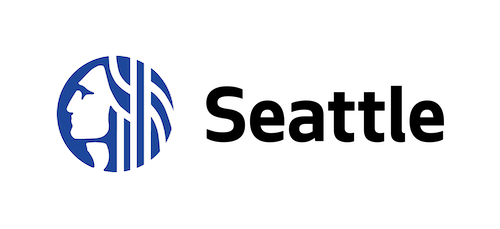

## <font color='#46abe6'>Notebook 2 - Prédiction de la consommation d'énergie 'SiteEnergyUse(kBtu)'</font>

<span style='background:#46abe6'><span style='color:white'>**Notebook 2_1 - Sélection du modèle**</span></span>

[Partie 1 - Importation des librairies et des données](#partie_1)

[Partie 2 - Sélection du meilleur modèle](#partie_2)

<span style='background:#46abe6'><span style='color:white'>**Notebook 2_2 - Optimisation du modèle**</span></span>

[Partie 3 - Optimisation du meilleur modèle](#partie_3)

[Partie 4 - Feature importance globale et locale](#partie_4)


<span style='background:#d5155b'><span style='color:white'>**Notebook 2_3 - Evaluation de l'influence de EnergyStarScore**</span></span>

[Partie 5 - Evaluation de l'influence de EnergyStarScore](#partie_5)
* [5.1. EnergyStarScore : objectifs et méthode de calcul](#5_1)
* [5.2. Echantillons d'entraînement et de test](#5_2)
* [5.3. Modèle de prédiction sans EnergyStar Score](#5_3)
* [5.4. Modèle de prédiction avec EnergyStar Score](#5_4)

[Conclusion & Perspectives](#partie_6)

# <font color='#0a389f'>Importation des librairies et des données<a class="anchor" id="partie_1"></a></font>

## <font color='#46abe6'>Importation des librairies<a class="anchor" id="1_1"></a></font>

In [1]:
import numpy as np
import pandas as pd

# graphiques
import matplotlib.pyplot as plt
import seaborn as sns

# affichage Markdown des Outputs
from IPython.display import Markdown 

# Encodeur pour les variables catégorielles
from sklearn.preprocessing import OneHotEncoder, TargetEncoder

# Standardisation des variables
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# Split entraînement /test
from sklearn.model_selection import train_test_split

# Cross validation
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, cross_validate

# Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer

# Modèles
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Métriques Evaluation du modèle
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error

import time

import scipy.stats as st

# Feature importance
import shap

import pickle

In [2]:
# Version python
!python --version
# Version des librairies utilisées
print('\n'.join(f'{m.__name__} - {m.__version__}' 
                for m in globals().values() 
                if getattr(m, '__version__', None)))

Python 3.11.4
numpy - 1.24.0
pandas - 2.1.1
seaborn - 0.13.0
shap - 0.44.1


In [3]:
# Paramètres par défauts des graphiques
sns.set_style('whitegrid')        # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)          # controls default text sizes
width = 7
height = 5
plt.figure(figsize=(width, height))
meanprops = {'marker':'o', 'markeredgecolor':'black','markerfacecolor':'firebrick'}

<Figure size 700x500 with 0 Axes>

In [4]:
# Initialisation de shap 
shap.initjs()

In [5]:
# Options d'affichage : toutes les colonnes et contenu complet de la colonne
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

## <font color='#46abe6'>Définition des fonctions<a class="anchor" id="1_2"></a></font>

In [6]:
def create_preprocessor(encoder, scaler, num_col, cat_col):
    """!
    @brief Crée un preprocesseur pour les données numériques et catégorielles.

    Cette fonction crée un preprocesseur qui applique les transformations spécifiées aux colonnes 
    numériques et catégorielles.

    @param encoder: Encoder pour encoder les variables catégorielles (type : Encoder).
    @param scaler: Scaler pour mettre à l'échelle les variables numériques (type : Scaler).
    @param num_col: Liste des noms des colonnes numériques (type : list[str]).
    @param cat_col: Liste des noms des colonnes catégorielles (type : list[str]).
    
    @return preprocessor: Preprocesseur pour les données numériques et catégorielles (type : ColumnTransformer).
    """
    
    # Columns: num_transformer = scaler, cat_transformer = encoder
    num_transformer = make_pipeline(scaler)
    cat_transformer = make_pipeline(encoder)

    # Associer encoder et scaler avec ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[('num', num_transformer, num_col),
                      ('cat', cat_transformer, cat_col)])

    
    return preprocessor

In [7]:
def search_best_params(pipe, param_grid, X_train, y_train, search_cv='GridSearchCV', score='r2', cv=5):
    """!
    @brief Recherche les meilleurs hyperparamètres pour un pipeline de modèle.

    Cette fonction utilise une recherche de grille ou une recherche aléatoire pour trouver les meilleurs hyperparamètres
    pour un pipeline de modèle donné.

    @param pipe: Pipeline de modèle à optimiser (type : sklearn.pipeline.Pipeline).
    @param param_grid: Grille des hyperparamètres à rechercher (type : dict).
    @param X_train: Features d'entraînement (type : array-like).
    @param y_train: Target d'entraînement (type : array-like).
    @param search_cv: Type de recherche à effectuer ('GridSearchCV' ou 'RandomizedSearchCV') (type : str, valeur par défaut : 'GridSearchCV').
    @param score: La métrique de score à utiliser pour l'optimisation (type : str, valeur par défaut : 'r2').
    @param cv: Le nombre de fold de validation croisée à utiliser (type : int, valeur par défaut : 5).
    
    @return best_model: Le meilleur modèle trouvé après l'optimisation des hyperparamètres (type : sklearn.pipeline.Pipeline).
    @return best_params_: Les meilleurs hyperparamètres trouvés (type : dict ou 'NA' si aucune recherche n'est effectuée).
    """
    
    if param_grid:
        # Recherche les meilleurs hyperparamètres par validation croisée
        if search_cv == 'GridSearchCV':
            grid_search = GridSearchCV(pipe, param_grid, cv=cv, scoring=score, n_jobs=-1)
        elif search_cv == 'RandomizedSearchCV':
            grid_search = RandomizedSearchCV(pipe, param_grid, cv=cv, scoring=score, n_jobs=-1)

        grid_search.fit(X_train, y_train)
        best_params_ = grid_search.best_params_
        best_model = grid_search.best_estimator_
    else:
        # Si le modèle n'a pas d'hyperparamètres, considère pipe comme best_model
        best_model = pipe
        best_params_ = 'NA'

    return best_model, best_params_

In [8]:
def evaluate_model(model, X_train, y_train, X_test, y_test, score='r2', cv=5):
    """!
    @brief Évalue les performances d'un modèle.

    Cette fonction évalue les performances d'un modèle en effectuant une validation croisée,
    en calculant plusieurs métriques de performance sur l'ensemble de test et en fournissant des informations
    sur le temps d'entraînement et de prédiction.

    @param model: Modèle à évaluer (type : sklearn.base.BaseEstimator).
    @param X_train: Features d'entraînement (type : array-like).
    @param y_train: Target d'entraînement (type : array-like).
    @param X_test: Features de test (type : array-like).
    @param y_test: Target de test (type : array-like).
    @param score: La métrique de score à utiliser pour l'évaluation (type : str, valeur par défaut : 'r2').
    @param cv: Le nombre de folds de validation croisée à utiliser (type : int, valeur par défaut : 5).
    
    @return results: Dictionnaire contenant les résultats de l'évaluation du modèle (type : dict).
    """    
    # Cross-validation sur le training set
    scores = cross_validate(model, X_train, y_train, scoring=score, cv=cv)
    cv_r2 = scores['test_score'].mean()
    cv_std = np.std(scores['test_score'])

    # Prédiction et scores 
    start_time = time.perf_counter() # début compteur pour les temps d'exécution du modèle
    model.fit(X_train, y_train) # Entraînement du modèle
    fit_time = time.perf_counter() # compteur entraînement
    y_pred = model.predict(X_test) # Prédiction 
    pred_time = time.perf_counter() # compteur prédiction
    y_pred_train = model.predict(X_train) # prédiction de y_train
       
    # Dictionnaire contenant tous les résultats
    results = {
        'cv_r2': cv_r2,
        'cv_std': cv_std,
        'train_r2': r2_score(y_train, y_pred_train),
        'test_r2': r2_score(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': root_mean_squared_error(y_test, y_pred),
        'fit_time': fit_time - start_time,
        'pred_time': pred_time - fit_time,
        'y_pred': y_pred,  
        'model': model  
    }

    return results

In [9]:
def feature_test( model,
                  test,
                  encoder, 
                  scaler, 
                  X_train, y_train, 
                  X_test, y_test, 
                  cat_col, num_col, 
                  score='r2', cv=5):
    """!
    @brief Teste les performances d'un modèle par un cas de test spécifique.

    Cette fonction réalise les étapes suivantes :
    1. Crée un pipeline avec le préprocesseur et le modèle donnés.
    2. Évalue les performances du modèle sur l'ensemble d'entraînement et de test.
    3. Ajoute les scores de performance dans un DataFrame global.

    @param model: Modèle à entraîner et évaluer (type : sklearn.base.BaseEstimator).
    @param test: Nom du cas de test (type : str).
    @param encoder: Encoder pour encoder les variables catégorielles (type : Encoder).
    @param scaler: Scaler pour mettre à l'échelle les variables numériques (type : Scaler).
    @param param_grid: Grille des hyperparamètres à rechercher (type : dict).
    @param X_train: Features d'entraînement (type : array-like).
    @param y_train: Target d'entraînement (type : array-like).
    @param X_test: Features de test (type : array-like).
    @param y_test: Target de test (type : array-like).
    @param cat_col: Liste des noms des colonnes catégorielles (type : list[str]).
    @param num_col: Liste des noms des colonnes numériques (type : list[str]).
    @param score: Métrique de score à utiliser pour l'évaluation (type : str, valeur par défaut : 'r2').
    @param cv: Nombre de folds de validation croisée à utiliser (type : int, valeur par défaut : 5).

    @return best_model_: Le meilleur modèle évalué sur les données de test (type : sklearn.pipeline.Pipeline).
    """    
    global energystarscore_df 
    
    # Créer le pipeline
    preprocessor = create_preprocessor(encoder, scaler, num_col, cat_col)
    pipe = make_pipeline(preprocessor, model)
    
    # Évaluation du modèle
    results = evaluate_model(pipe, X_train, y_train, X_test, y_test, score='r2', cv=5)
    
    best_model_ = results['model']

    # Cross-validation et scores sur le testing test : ajout à energystarscore_df
    new_row = pd.DataFrame({
        'Model': str(model),
        'Test' : test,
        'CV_R2 score': "{:.3f} (+/- {:.03f})".format(results['cv_r2'], results['cv_std']),
        'Train_R2 score': round(results['train_r2'], 3),
        'Test_R2 score': round(results['test_r2'], 3),
        'Test_MAE': round(results['MAE'], 3),
        'Test_RMSE': round(results['RMSE'], 3),
        'Fit Time (s)': round(results['fit_time'], 3),
        'Prediction Time (s)': round(results['pred_time'], 3)
    }, index=[0])
    
    # Ajouter la nouvelle ligne à eval_df
    energystarscore_df = pd.concat([energystarscore_df, new_row],ignore_index=True)
    
    # Afficher le dataframe résultat
    print(f"Combinaison Encoder: {encoder}, Scaler: {scaler}, Model : {model}")
    display(energystarscore_df)
    
    return best_model_

In [10]:
def plot_metrics_comparison(df, comparison_feature, title, legend_bbox_to_anchor=(1, 1)):
    """!
    @brief Affiche des diagrammes à barres pour comparer les modèles sur différentes métriques.

    Cette fonction prend un DataFrame contenant les résultats des modèles pour une comparaison spécifique
    et affiche des diagrammes à barres pour chaque métrique spécifiée.

    @param df: DataFrame contenant les résultats des modèles pour une comparaison spécifique (type : pd.DataFrame).
    @param comparison_feature: Nom du test ou de la condition comparé (type : str).
    @param title: Titre du graphique (type : str).
    @param legend_bbox_to_anchor: Position de la légende en termes de coordonnées de la boîte englobante (type : tuple, valeur par défaut : (1, 1)).
    """
    metrics=['Train_R2 score', 'Test_R2 score','Test_MAE', 'Test_RMSE', 'Fit Time (s)', 'Prediction Time (s)']
    
    # Affichage de diagrammes à barres pour comparer les modèles 
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10), tight_layout=True)
    axes = axes.flatten()  # liste plate pour itération
    fig.suptitle(title, wrap=True, fontsize=24)

    # un graphique par métrique
    for i, metric in enumerate(metrics):
        plot_data = df[[comparison_feature, metric]].melt(id_vars=[comparison_feature], var_name='Metrics', value_name='Value')
        ax = sns.barplot(data=plot_data, x='Metrics', y='Value', hue=comparison_feature, palette='viridis', ax=axes[i])
        ax.set_title(f'{metric} des différents modèles')
        ax.get_legend().remove()
        
        for bars in ax.containers:
            ax.bar_label(bars, fontsize=15)

    # Afficher la légende avec bbox_to_anchor
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, bbox_to_anchor=legend_bbox_to_anchor)
    plt.show()

## <font color='#46abe6'>Importation des données<a class="anchor" id="1_3"></a></font>

In [11]:
# Importation du modèle optimisé et des paramètres associés
gbr_best_params = pickle.load(open('gbr_best_params_energy.pkl', 'rb'))
best_params = {key.replace('gradientboostingregressor__', ''): value for key, value in gbr_best_params.items()}

In [12]:
# Importation du dataframe nettoyé
data_ENERGYSTARScore = pd.read_pickle('data_ENERGYSTARScore.pkl')
data_ENERGYSTARScore.head()

,OSEBuildingID,PrimaryPropertyType,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,BuildingAge,PropertyGFAParking(%),PropertyGFABuilding(%),SteamUse(%),ElectricityUse(%),NaturalGasUse(%)
0,1,Hotel,downtown,1.0,12,88434,60.0,7226362.5,249.98,89,0.00,1.00,0.28,0.55,0.18
1,2,Hotel,downtown,1.0,11,103566,61.0,8387933.0,295.86,20,0.15,0.85,0.00,0.39,0.61
2,3,Hotel,downtown,1.0,41,956110,43.0,72587024.0,2089.28,47,0.21,0.79,0.30,0.68,0.02
3,5,Hotel,downtown,1.0,10,61320,56.0,6794584.0,286.43,90,0.00,1.00,0.33,0.41,0.27
4,8,Hotel,downtown,1.0,18,175580,75.0,14172606.0,505.01,36,0.35,0.65,0.00,0.38,0.62


# <font color='#0a389f'>Partie 5 - Analyse de l’influence de l’EnergyStarScore<a class="anchor" id="partie_5"></a></font>

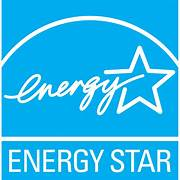

## <font color='#46abe6'>5.1. EnergyStarScore : objectifs et méthode de calcul<a class="anchor" id="3_1"></a></font>

L'**ENERGY STAR** score est une mesure de l'efficacité énergétique relative d'un bâtiment par rapport à des bâtiments similaires du pays. 

Les principaux objectifs de l'ENERGY STAR score:
* Évaluer le rendement énergétique d'un bâtiment dans son ensemble.
* Refléter les données de la consommation d'énergie réellement mesurée.
* Prendre en considération de façon équitable les différentes sources d'énergie.
* Normaliser en fonction des activités d'un bâtiment.
* Offrir une analyse comparative à un groupe de bâtiments semblables

Les données utilisées pour le calcul de l'ENERGY STAR score sont : 
* Données de consommation d'énergie complètes sur 12 mois pour tous les types d'énergie.
* Données physiques précises sur le bâtiment (surface du bâtiment, emplacement, type d'utilisation, âge du bâtiment, équipements installés, etc.).
* Données de consommation précises décrivant les activités du bâtiment (heures d'exploitation, etc.).
* Données météorologiques

Un modèle de régression est utilisé pour prédire la consommation d'énergie attendue d'un bâtiment en fonction de ses caractéristiques. L'ENERGY STAR score est ensuite calculé en comparant la consommation d'énergie réelle du bâtiment à la consommation d'énergie estimée par le modèle. Ce score est généralement compris entre 1 et 100, où score plus élevé indique une meilleure performance énergétique par rapport aux bâtiments similaires.

Sources : 
- [La Cote ENERGY STAR](https://portfoliomanager.energystar.gov/pdf/reference/ENERGY%20STAR%20Score_fr_CA.pdf)
- [How the 1–100 ENERGY STAR Score is Calculated](https://www.energystar.gov/buildings/benchmark/understand_metrics/how_score_calculated)

###  <font color='#46abe6'>5.2. Echantillons d'entraînement et de test<a class="anchor" id="5_2"></a></font>

In [13]:
# Transformation au log
data_ENERGYSTARScore['log_NumberofFloors'] = np.log10(data_ENERGYSTARScore['NumberofFloors'])
data_ENERGYSTARScore['log_PropertyGFATotal'] = np.log10(data_ENERGYSTARScore['PropertyGFATotal'])
data_ENERGYSTARScore['log_SiteEnergyUse(kBtu)'] = np.log10(data_ENERGYSTARScore['SiteEnergyUse(kBtu)'])

In [14]:
seed = 0

# Définition des variables d'entrée X et de la target y
X_esc = data_ENERGYSTARScore[['PrimaryPropertyType', 
                           'Neighborhood', 
                           'BuildingAge',
                           'NumberofBuildings', 
                           'log_NumberofFloors', 
                           'log_PropertyGFATotal',
                           'PropertyGFAParking(%)',
                           'PropertyGFABuilding(%)', 
                           'SteamUse(%)', 
                           'ElectricityUse(%)',
                           'NaturalGasUse(%)', 
                           'ENERGYSTARScore']]

y_esc = data_ENERGYSTARScore['log_SiteEnergyUse(kBtu)']

In [15]:
# Création de l'échantillon d'entraînement et de l'échantillon de test
# Stratify = répartition homogène de 'PrimaryPropertyType' dans les échantillons des tests et entraînement
X_train_esc, X_test_esc, y_train_esc, y_test_esc = train_test_split(X_esc, y_esc, 
                                                    test_size=0.2, 
                                                    stratify=data_ENERGYSTARScore['PrimaryPropertyType'], 
                                                    random_state = seed)

print(f'Dimensions de X_train dataset EnergyStarScore : {X_train_esc.shape}')
print(f'Dimensions de X_test dataset EnergyStarScore : {X_test_esc.shape}')

Dimensions de X_train dataset EnergyStarScore : (692, 12)
Dimensions de X_test dataset EnergyStarScore : (173, 12)


In [16]:
energystarscore_df = pd.DataFrame()

## <font color='#46abe6'>5.3. Modèle de prédiction sans EnergyStar Score<a class="anchor" id="5_3"></a></font>

### Evaluation du modèle

In [17]:
X_train_baseline = X_train_esc.drop(columns='ENERGYSTARScore') 
X_test_baseline = X_test_esc.drop(columns='ENERGYSTARScore') 

In [18]:
# Définition des variables à encoder et standardiser
cat_col = ['Neighborhood', 
           'PrimaryPropertyType']

num_col = X_train_baseline.columns.difference(cat_col).to_list()

In [19]:
encoder = OneHotEncoder()
scaler = RobustScaler()
best_model = GradientBoostingRegressor(**best_params)

model_without_energystarscore = feature_test( best_model,
                                              'without EnergyStarScore',
                                              encoder, 
                                              scaler, 
                                              X_train_baseline, y_train_esc, 
                                              X_test_baseline, y_test_esc, 
                                              cat_col, num_col, 
                                              score='r2', cv=5)

Combinaison Encoder: OneHotEncoder(), Scaler: RobustScaler(), Model : GradientBoostingRegressor(min_samples_split=3)


,Model,Test,CV_R2 score,Train_R2 score,Test_R2 score,Test_MAE,Test_RMSE,Fit Time (s),Prediction Time (s)
0,GradientBoostingRegressor(min_samples_split=3),without EnergyStarScore,0.783 (+/- 0.039),0.896,0.796,0.176,0.23,0.107,0.003


### Feature importance globale et locale

In [20]:
# Preprocessing pour X_test
preprocessor_baseline = create_preprocessor(encoder, scaler, num_col, cat_col)

# Fit sur X_train
X_train_baseline_transformed = preprocessor_baseline.fit_transform(X_train_baseline)

# Transformer X_test
X_test_baseline_transformed = preprocessor_baseline.transform(X_test_baseline).toarray()

In [21]:
# Extraire le modèle final du pipeline
final_model_without = model_without_energystarscore.named_steps['gradientboostingregressor']

In [22]:
# Feature importance locale
explainer_without = shap.TreeExplainer(final_model_without)
shap_values = explainer_without.shap_values(X_test_baseline_transformed)
local_feature_importance_without = shap_values

#### Feature importance globale

In [23]:
# Feature importance globale
global_feature_importance_without = final_model_without.feature_importances_

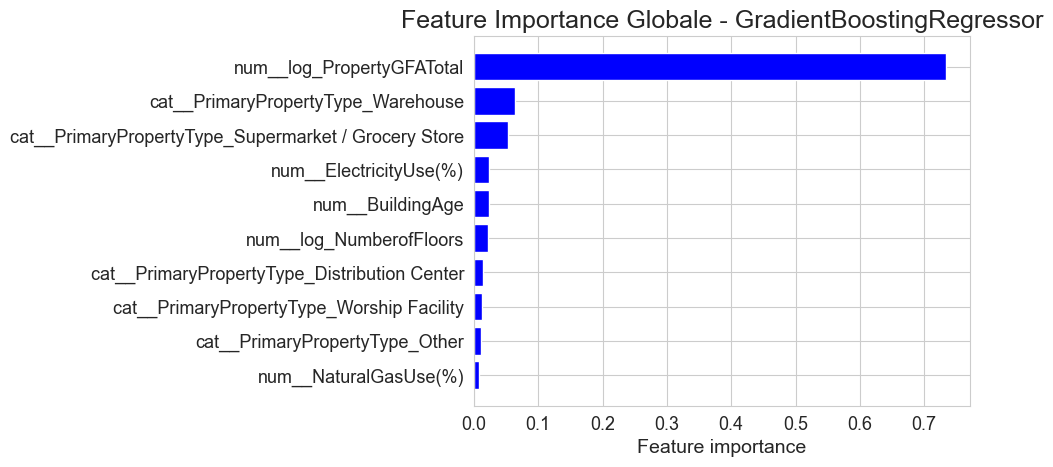

In [24]:
top_x = 10
indices = np.argsort(global_feature_importance_without)
indices = indices[-top_x:]

plt.barh(range(len(indices)), global_feature_importance_without[indices], color='b', align='center') 
plt.title('Feature Importance Globale - GradientBoostingRegressor')
plt.yticks(range(len(indices)), [preprocessor_baseline.get_feature_names_out()[i] for i in indices]) 
plt.xlabel('Feature importance')
plt.show()

* **Summary plot**

Le summary plot montre la distribution des valeurs SHAP de l'échantillon de test pour toutes les variables. Il montre également le lien entre les valeurs des variables et leurs contributions. 

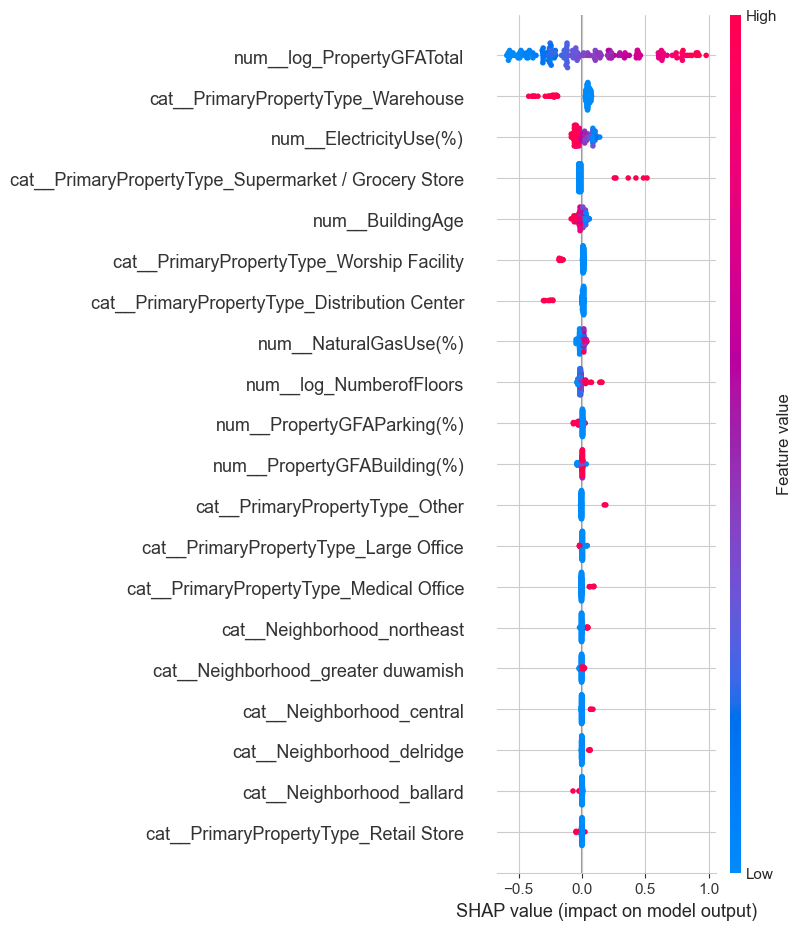

In [25]:
shap.summary_plot(explainer_without.shap_values(X_test_baseline_transformed),
                  features = X_test_baseline_transformed,
                  feature_names=preprocessor_baseline.get_feature_names_out())

#### Feature importance locale


Le force plot montre les contributions des valeurs SHAP dans la génération de la prédiction finale en utilisant une disposition de force additive. Il montre quelles caractéristiques ont contribué positivement ou négativement à la valeur de base pour générer une prédiction.

* **Analyse d'un élément de la catégorie la plus fréquente 'Small- and Mid-Sized Office'**

In [26]:
index = 416
loc = X_test_baseline.index.get_loc(index)
data_ENERGYSTARScore.loc[index]

OSEBuildingID                                      575
PrimaryPropertyType        Small- and Mid-Sized Office
Neighborhood                                 northwest
NumberofBuildings                                  1.0
NumberofFloors                                       5
PropertyGFATotal                                 86400
ENERGYSTARScore                                   53.0
SiteEnergyUse(kBtu)                          9080022.0
TotalGHGEmissions                               293.55
BuildingAge                                         42
PropertyGFAParking(%)                              0.0
PropertyGFABuilding(%)                             1.0
SteamUse(%)                                        0.0
ElectricityUse(%)                                 0.45
NaturalGasUse(%)                                  0.55
log_NumberofFloors                             0.69897
log_PropertyGFATotal                          4.936514
log_SiteEnergyUse(kBtu)                       6.958087
Name: 416,

In [27]:
# force plot 
shap.force_plot(explainer_without.expected_value, 
                explainer_without.shap_values(X_test_baseline_transformed[loc]), 
                X_test_baseline_transformed[loc], 
                feature_names=preprocessor_baseline.get_feature_names_out(),
                out_names="log_SiteEnergyUse(kBtu)")

* **Analyse d'un élément d'une catégorie peu fréquente 'Senior Care Community'**

In [28]:
index = 966
loc = X_test_baseline.index.get_loc(index)
data_ENERGYSTARScore.loc[index]

OSEBuildingID                              20377
PrimaryPropertyType        Senior Care Community
Neighborhood                           southeast
NumberofBuildings                            1.0
NumberofFloors                                 3
PropertyGFATotal                           78374
ENERGYSTARScore                             98.0
SiteEnergyUse(kBtu)                   3321035.75
TotalGHGEmissions                          23.15
BuildingAge                                   35
PropertyGFAParking(%)                        0.0
PropertyGFABuilding(%)                       1.0
SteamUse(%)                                  0.0
ElectricityUse(%)                            1.0
NaturalGasUse(%)                             0.0
log_NumberofFloors                      0.477121
log_PropertyGFATotal                    4.894172
log_SiteEnergyUse(kBtu)                 6.521274
Name: 966, dtype: object

In [29]:
# force plot 
shap.force_plot(explainer_without.expected_value, 
                explainer_without.shap_values(X_test_baseline_transformed[loc]), 
                X_test_baseline_transformed[loc], 
                feature_names=preprocessor_baseline.get_feature_names_out(),
                out_names="log_SiteEnergyUse(kBtu)")

* **Analyse d'un outlier identifié dans l'analyse exploratoire**

In [30]:
index = 477
loc = X_test_baseline.index.get_loc(index)
data_ENERGYSTARScore.loc[index]

OSEBuildingID                           640
PrimaryPropertyType            Large Office
Neighborhood               greater duwamish
NumberofBuildings                       1.0
NumberofFloors                            6
PropertyGFATotal                    1380959
ENERGYSTARScore                        79.0
SiteEnergyUse(kBtu)              74130576.0
TotalGHGEmissions                     810.7
BuildingAge                             104
PropertyGFAParking(%)                   0.0
PropertyGFABuilding(%)                  1.0
SteamUse(%)                             0.0
ElectricityUse(%)                      0.91
NaturalGasUse(%)                       0.09
log_NumberofFloors                 0.778151
log_PropertyGFATotal               6.140181
log_SiteEnergyUse(kBtu)            7.869997
Name: 477, dtype: object

In [31]:
# force plot 
shap.force_plot(explainer_without.expected_value, 
                explainer_without.shap_values(X_test_baseline_transformed[loc]), 
                X_test_baseline_transformed[loc], 
                feature_names=preprocessor_baseline.get_feature_names_out(),
                out_names="log_SiteEnergyUse(kBtu)")

## <font color='#46abe6'>5.4. Modèle de prédiction avec EnergyStar Score<a class="anchor" id="5_4"></a></font>

### Evaluation du modèle

In [32]:
# Définition des variables à encoder et standardiser
cat_col_esc = ['Neighborhood', 
           'PrimaryPropertyType']

num_col_esc = X_train_esc.columns.difference(cat_col).to_list()

In [33]:
encoder = OneHotEncoder()
scaler = RobustScaler()
best_model = GradientBoostingRegressor(**best_params)

model_with_esc = feature_test( best_model,
                               'with EnergyStarScore',
                               encoder, 
                               scaler, 
                               X_train_esc, y_train_esc, 
                               X_test_esc, y_test_esc, 
                               cat_col_esc, num_col_esc, 
                               score='r2', cv=5)

Combinaison Encoder: OneHotEncoder(), Scaler: RobustScaler(), Model : GradientBoostingRegressor(min_samples_split=3)


,Model,Test,CV_R2 score,Train_R2 score,Test_R2 score,Test_MAE,Test_RMSE,Fit Time (s),Prediction Time (s)
0,GradientBoostingRegressor(min_samples_split=3),without EnergyStarScore,0.783 (+/- 0.039),0.896,0.796,0.176,0.230,0.107,0.003
1,GradientBoostingRegressor(min_samples_split=3),with EnergyStarScore,0.868 (+/- 0.037),0.955,0.897,0.131,0.163,0.119,0.003


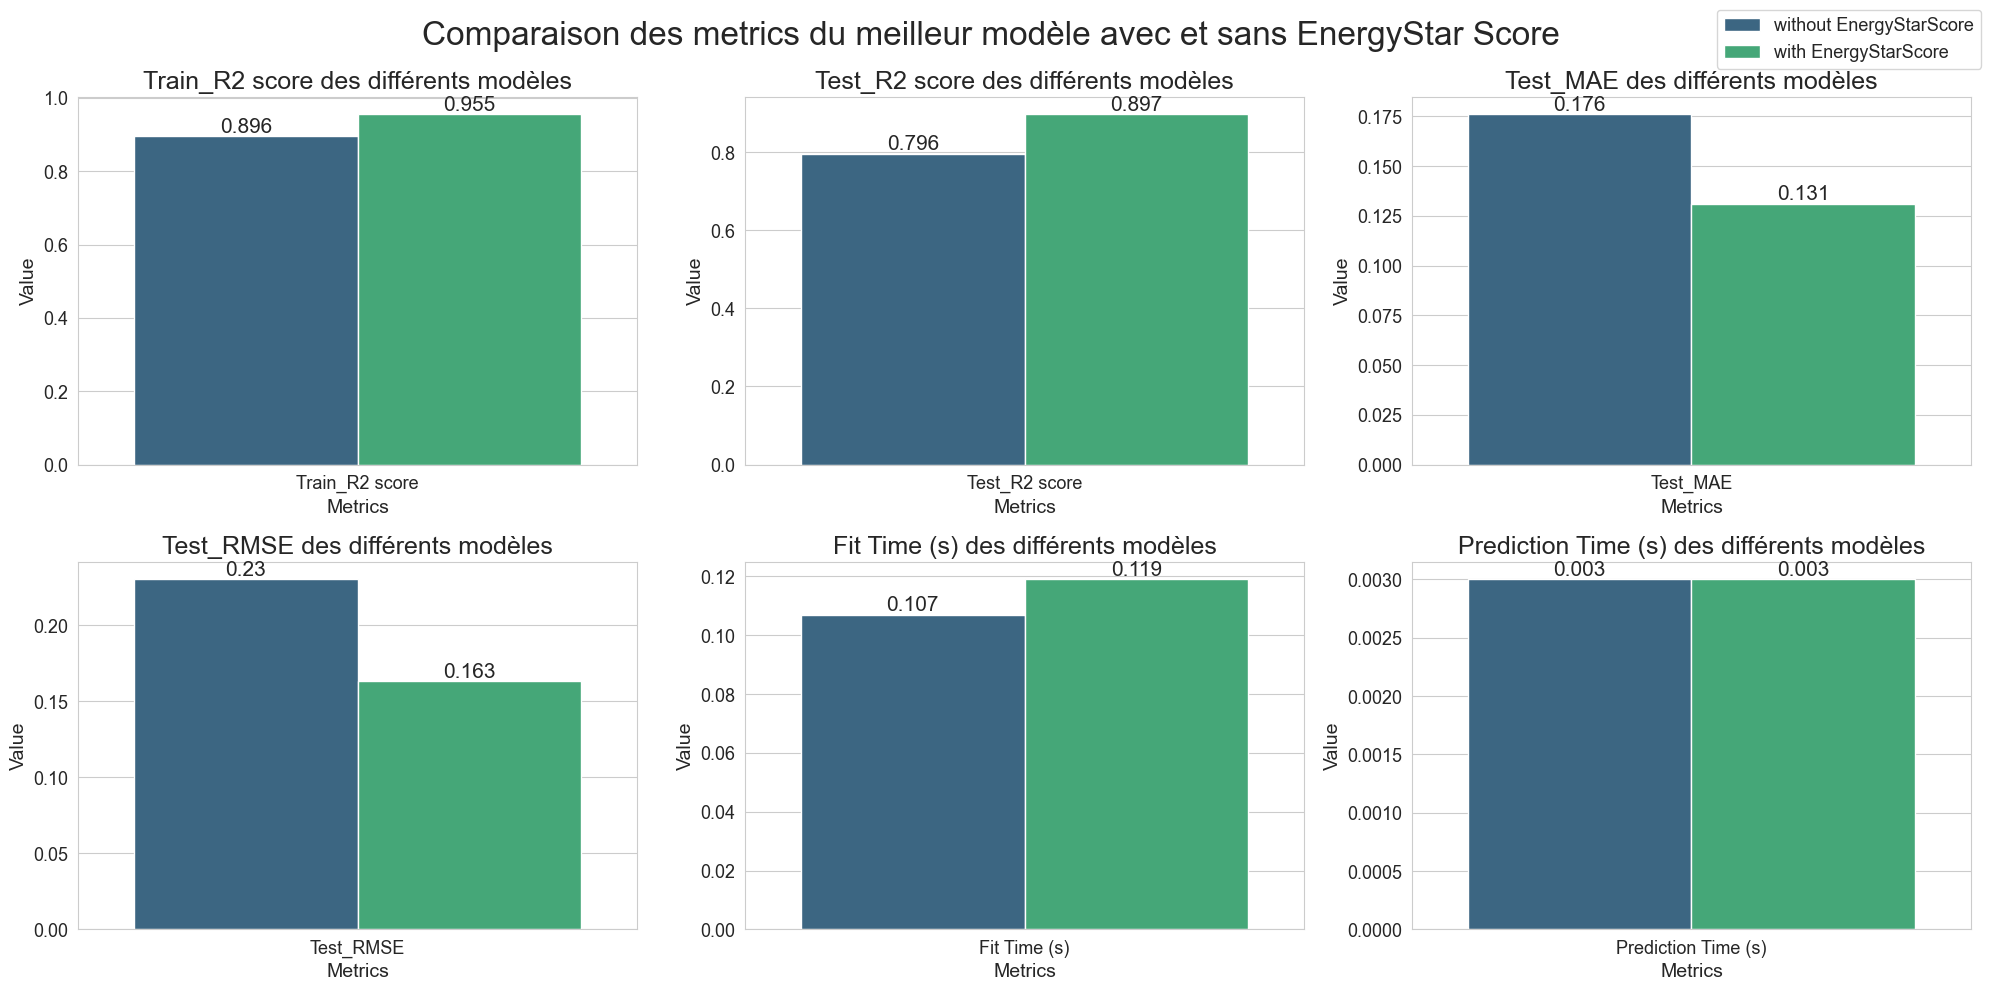

In [34]:
# Affichage de diagrammes à barres pour comparer les résultats avec ou sans Energy Star score
title = 'Comparaison des metrics du meilleur modèle avec et sans EnergyStar Score'
plot_metrics_comparison(energystarscore_df, 'Test', title, legend_bbox_to_anchor=(1, 1))

L'ajout de l'EnergyStarScore a permis d'améliorer les performances du modèle

### Feature importance globale et locale

In [35]:
# Preprocessing pour X_test
preprocessor_esc = create_preprocessor(encoder, scaler, num_col_esc, cat_col_esc)

# Fit sur X_train
X_train_esc_transformed = preprocessor_esc.fit_transform(X_train_esc)

# Transformer X_test
X_test_esc_transformed = preprocessor_esc.transform(X_test_esc)

In [36]:
# Extraire le modèle final du pipeline
final_model_esc = model_with_esc.named_steps['gradientboostingregressor']

In [37]:
# Feature importance locale
explainer_esc = shap.TreeExplainer(final_model_esc)
shap_values = explainer_esc.shap_values(X_test_esc_transformed)
local_feature_importance_esc = shap_values

#### Feature importance globale

In [38]:
# Feature importance globale
global_feature_importance_esc = final_model_esc.feature_importances_

L'EnergyStarScore est la 2ième variable la plus importante dans les contributions.

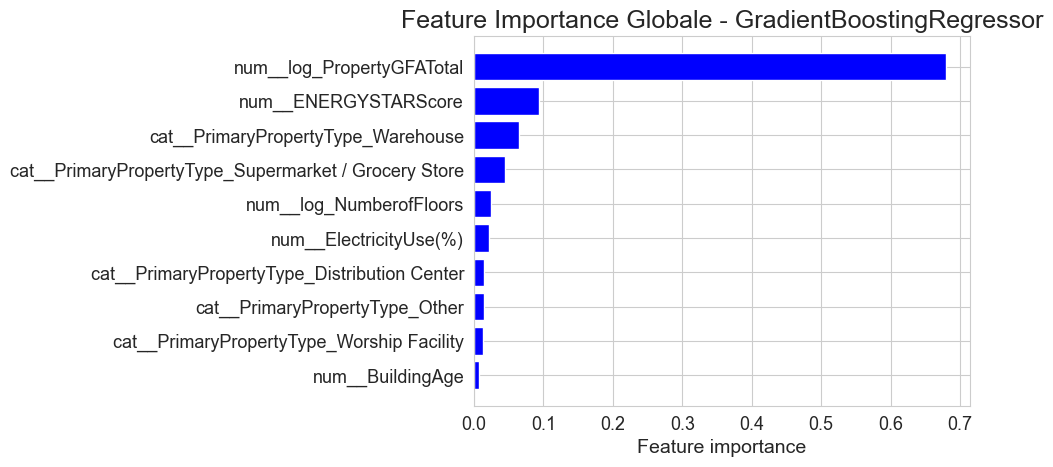

In [39]:
top_x = 10
indices = np.argsort(global_feature_importance_esc)
indices = indices[-top_x:]

plt.barh(range(len(indices)), global_feature_importance_esc[indices], color='b', align='center') 
plt.title('Feature Importance Globale - GradientBoostingRegressor')
plt.yticks(range(len(indices)), [preprocessor_esc.get_feature_names_out()[i] for i in indices]) 
plt.xlabel('Feature importance')
plt.show()

* **Summary plot**
Un EnergyStarScore élevé fait diminuer la prédiction par rapport à la baseline : cela est logique car un score plus élevé indique une meilleure performance énergétique par rapport aux bâtiments similaires.

- PropertyGFATotal reste la feature qui a la contribution la plus importante.
- ENERGYSTARScore est la 2ième feature la plus importante : un score élevé implique contribution négative et vice versa. Cela est logique car un score élevé correspond à un bâtiment avec une meilleure performance énergétique qu'un bâtiment similaire.
- PrimaryPropertyType_Warehouse et ElectricityUse(%) restent des features importantes.
- BuildingAge est moins importante ici.

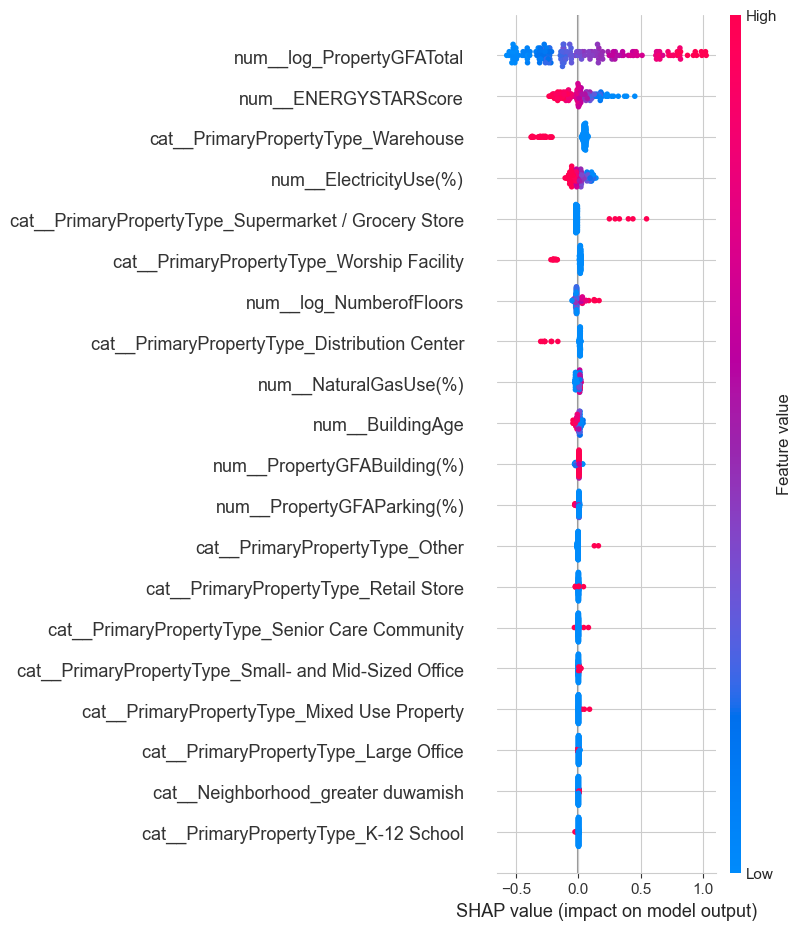

In [40]:
shap.summary_plot(explainer_esc.shap_values(X_test_esc_transformed),
                  features = X_test_esc_transformed,
                  feature_names=preprocessor_esc.get_feature_names_out())

#### Feature importance locale


Le force plot montre les contributions des valeurs SHAP dans la génération de la prédiction finale en utilisant une disposition de force additive. Il montre quelles caractéristiques ont contribué positivement ou négativement à la valeur de base pour générer une prédiction.

Pour 2 des éléments analysés, ENERGYSTARScore fait maintenant partie des features qui ont une contribution importante sur la prédiction finale. Elle a permis d'augmenter la prédiction dans un cas et de la diminuer dans l'autre.

* **Analyse d'un élément de la catégorie la plus fréquente 'Small- and Mid-Sized Office'**

In [41]:
index = 416
loc = X_test_esc.index.get_loc(index)
data_ENERGYSTARScore.loc[index]

OSEBuildingID                                      575
PrimaryPropertyType        Small- and Mid-Sized Office
Neighborhood                                 northwest
NumberofBuildings                                  1.0
NumberofFloors                                       5
PropertyGFATotal                                 86400
ENERGYSTARScore                                   53.0
SiteEnergyUse(kBtu)                          9080022.0
TotalGHGEmissions                               293.55
BuildingAge                                         42
PropertyGFAParking(%)                              0.0
PropertyGFABuilding(%)                             1.0
SteamUse(%)                                        0.0
ElectricityUse(%)                                 0.45
NaturalGasUse(%)                                  0.55
log_NumberofFloors                             0.69897
log_PropertyGFATotal                          4.936514
log_SiteEnergyUse(kBtu)                       6.958087
Name: 416,

In [42]:
# force plot
shap.force_plot(explainer_esc.expected_value, 
                explainer_esc.shap_values(X_test_esc_transformed[loc]), 
                X_test_esc_transformed[loc], 
                feature_names=preprocessor_esc.get_feature_names_out(),
                out_names="log_SiteEnergyUse(kBtu)")

* **Analyse d'un élément d'une catégorie peu fréquente 'Senior Care Community'**

In [43]:
index = 966
loc = X_test_esc.index.get_loc(index)
data_ENERGYSTARScore.loc[index]

OSEBuildingID                              20377
PrimaryPropertyType        Senior Care Community
Neighborhood                           southeast
NumberofBuildings                            1.0
NumberofFloors                                 3
PropertyGFATotal                           78374
ENERGYSTARScore                             98.0
SiteEnergyUse(kBtu)                   3321035.75
TotalGHGEmissions                          23.15
BuildingAge                                   35
PropertyGFAParking(%)                        0.0
PropertyGFABuilding(%)                       1.0
SteamUse(%)                                  0.0
ElectricityUse(%)                            1.0
NaturalGasUse(%)                             0.0
log_NumberofFloors                      0.477121
log_PropertyGFATotal                    4.894172
log_SiteEnergyUse(kBtu)                 6.521274
Name: 966, dtype: object

In [44]:
# force plot
shap.force_plot(explainer_esc.expected_value, 
                explainer_esc.shap_values(X_test_esc_transformed[loc]), 
                X_test_esc_transformed[loc], 
                feature_names=preprocessor_esc.get_feature_names_out(),
                out_names="log_SiteEnergyUse(kBtu)")

* **Analyse d'un outlier identifié dans l'analyse exploratoire**

In [45]:
index = 477
loc = X_test_esc.index.get_loc(index)
data_ENERGYSTARScore.loc[index]

OSEBuildingID                           640
PrimaryPropertyType            Large Office
Neighborhood               greater duwamish
NumberofBuildings                       1.0
NumberofFloors                            6
PropertyGFATotal                    1380959
ENERGYSTARScore                        79.0
SiteEnergyUse(kBtu)              74130576.0
TotalGHGEmissions                     810.7
BuildingAge                             104
PropertyGFAParking(%)                   0.0
PropertyGFABuilding(%)                  1.0
SteamUse(%)                             0.0
ElectricityUse(%)                      0.91
NaturalGasUse(%)                       0.09
log_NumberofFloors                 0.778151
log_PropertyGFATotal               6.140181
log_SiteEnergyUse(kBtu)            7.869997
Name: 477, dtype: object

In [46]:
# force plot
shap.force_plot(explainer_esc.expected_value, 
                explainer_esc.shap_values(X_test_esc_transformed[loc]), 
                X_test_esc_transformed[loc], 
                feature_names=preprocessor_esc.get_feature_names_out(),
                out_names="log_SiteEnergyUse(kBtu)")

# <font color='#0a389f'>Conclusion & Perspectives<a class="anchor" id="partie_6"></a></font>

L'Energy Star Score est une variable d'intérêt pour la prédiction de consommation d'énergie 'SiteEnergyUse(kBtu)'.
Il a permis d'améliorer les performances du modèles et a une contribution très importante sur les prédictions finales.
Un relevé sera nécessaire sur une année afin de calculer l'EnergyStarScore.

* Perspectives : Pour améliorer encore le modèle, nous pourrions également tester : 
    - un modèle par catégorie de bâtiment
    - utilisation des LargestPropertyUseType
    - augmentation des données pour les catégories de bâtiment les moins importantes (en prenant des bâtiments des villes voisines par exemple)
    - vérifier les hypothèses de mix énergétique des bâtiments en regardant les données disponibles pour les autres années
